<a href="https://colab.research.google.com/github/Reennon/gen-ai-cv-lab-1/blob/main/notebooks/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN CIFAR-10 Training and Experimentation

This notebook demonstrates training GAN model on the CIFAR-10 dataset using a modular training pipeline implemented in PyTorch Lightning.


In [1]:
!git clone https://github.com/Reennon/gen-ai-cv-lab-1.git
%cd gen-ai-cv-lab-1

Cloning into 'gen-ai-cv-lab-1'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 339 (delta 16), reused 27 (delta 8), pack-reused 299 (from 1)
Receiving objects: 100% (339/339), 353.93 KiB | 1.41 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/gen-ai-cv-lab-1


In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 58.5 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=431011e702087c89caf755d2cb20d55c0f0b2c4fb8668005b8836a163fbdc539
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


In [3]:
!git pull

Already up to date.


In [4]:
import os
import dotenv
import wandb
import torch

from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from google.colab import userdata
from matplotlib import pyplot as plt

from src.visualization.gan_visualizer import GANVisualizer
from src.training.trainer import train_model
from src.models.gan import GAN


In [6]:
os.environ["WANDB_KEY"] = userdata.get("wandb_key")
!echo $WANDB_KEY >> .env

In [7]:
dotenv.load_dotenv()

True

In [8]:
parameters = OmegaConf.load("./params/gan.yml")
wandb.login(key=os.environ["WANDB_KEY"])

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
wandb_project_name = "cifar-10-gan"
device = "gpu"

In [11]:
# Define data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Corrected for 3 channels
])

# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(1.)


In [13]:
images.shape

torch.Size([64, 3, 32, 32])

In [14]:
hparams = parameters.hyperparameters

In [15]:
# Edit hparams dict here as experiemnt, wandb will log the difference
# hparams["lr"] = 1e-4
# hparams["epochs"] = 20
# hparams['latent_dim'] = 48

parameters.run_parameters.experiment_name = f"gan-{hparams['latent_dim']}-lr-{hparams['lr']}-epochs-{hparams['epochs']}"

dict(hparams)

{'lr': 0.0002, 'epochs': 50, 'latent_dim': 100}

In [16]:
wandb.finish()

In [17]:
parameters

{'run_parameters': {'experiment_name': 'gan-100-lr-0.0002-epochs-50'}, 'hyperparameters': {'lr': 0.0002, 'epochs': 50, 'latent_dim': 100}, 'training': {'accelerator': 'gpu', 'devices': 1}}

In [18]:
# Train the Gan
model = train_model(GAN, parameters, train_loader, val_loader, wandb_project_name)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: rkovalch (rkovalchuk). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 3.9 M  | train
1 | discriminator | Discriminator | 1.7 M  | train
--------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.226    Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/content/gen-ai-cv-lab-1/src/models/gan.py:34: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  z = Variable(Tensor(np.random.normal(0, 1, (z.shape[0], self.latent_dim))))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [19]:
GAN(parameters.hyperparameters)

GAN(
  (generator): Generator(
    (model): Sequential(
      (0): Linear(in_features=100, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Linear(in_features=128, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Linear(in_features=256, out_features=512, bias=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Linear(in_features=512, out_features=1024, bias=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Linear(in_features=1024, out_features=3072, bias=True)
      (9): Tanh()
    )
  )
  (discriminator): Discriminator(
    (model): Sequential(
      (0): Linear(in_features=3072, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Linear(in_features=256, out_features=1, bias=True)
      (5): Si

In [20]:
# Visualize metrics from wandb
from IPython.display import display
wandb_url = wandb.run.get_url()
display(f"Wandb Dashboard: {wandb_url}")


'Wandb Dashboard: https://wandb.ai/rkovalchuk/cifar-10-gan/runs/hznuah9v'

In [21]:
wandb.finish()

d_loss,▁▆▄▄▃█▅▅▅▄▅▅▆▅▄▄▅▅▆▄▅▆▅▆▄▅▆▅▅▅▅▅▅▇▆▆▇▆▆▆
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
g_loss,▂█▆▇█▅▆▅▆▅▄▄▄▃▄▂▅▃▂▄▄▃▃▂▄▂▃▂▃▃▃▄▂▁▂▂▂▂▂▁
learning_rate_optimizer_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate_optimizer_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
val_d_loss,▁▂▅▄▆▃▅▄▆▅▆▅▄▅▆▄▅▅▄▆▅▆▆▄▅▅▆▅▇▅▇▆▅█▇▇▇▇█▆
val_g_loss,▇▆▇▅▅▄▆▄▆▅█▃▅▅▁▂▅▃▇▃▂▄▃▃▄▄▃▂▄▄▃▃▃▁▃▂▁▁▂▂
val_loss,▆█▅▆▅▇▄▇▅▄▄▆▂▃▂▄█▃▃▂▄▃▄▄▄▃▅▄▂▃▅▃▁▄▄▂▂▃▂▂
d_loss,0.66304
epoch,49


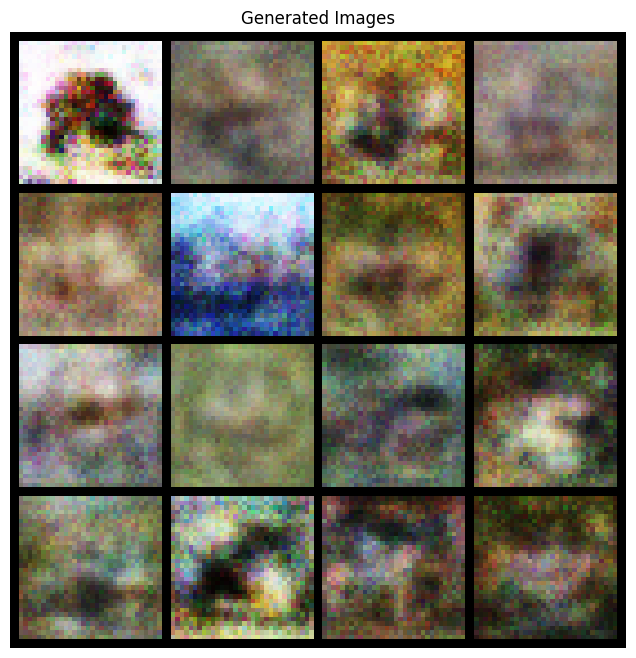

In [22]:
# Load the trained model
model.eval()

# Create the visualizer
visualizer = GANVisualizer(model, latent_dim=100)

# Visualize generated images
visualizer.visualize_generated_images(num_samples=16)